In [450]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN, approximate_predict
from hdbscan.prediction import membership_vector
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from category_encoders import CatBoostEncoder
from copy import deepcopy
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

pd.set_option('display.max_columns', None)

In [451]:
flight_data_train = pd.read_csv('./flight_data_train_ts_wx.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts_wx.csv')

In [452]:
flight_data_train.columns

Index(['scheduledoffblocktime', 'traffictypecode', 'airlinecode_iata',
       'destination_iata', 'aircraft_iata', 'isconnecting', 'publicgatenumber',
       'aircraftterminal', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti',
       'vsby', 'gust', 'skyc1', 'skyc2', 'skyl1', 'wxcodes',
       'finalflightstatus', 'delay_in_secs'],
      dtype='object')

In [453]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

# flight_data_train.sort_values(by='scheduledoffblocktime', inplace=True)
# flight_data_test.sort_values(by='scheduledoffblocktime', inplace=True)

Feature Selection

In [454]:
def chi_2(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic for {x} and {y}: {chi2}, p-value: {p}, dof:{dof}")

In [455]:
def cramers_v(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cor = np.sqrt(chi2 / (n * min_dim))
    print(f"Cramer's V  for {x} and {y}: {cor}, p-value: {p}")

In [456]:
flight_data_train.columns

Index(['scheduledoffblocktime', 'traffictypecode', 'airlinecode_iata',
       'destination_iata', 'aircraft_iata', 'isconnecting', 'publicgatenumber',
       'aircraftterminal', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti',
       'vsby', 'gust', 'skyc1', 'skyc2', 'skyl1', 'wxcodes',
       'finalflightstatus', 'delay_in_secs'],
      dtype='object')

In [457]:
chi_2(flight_data_train, 'publicgatenumber', 'finalflightstatus')
cramers_v(flight_data_train, 'publicgatenumber', 'finalflightstatus')

Chi-Square Statistic for publicgatenumber and finalflightstatus: 4157.193423282626, p-value: 0.0, dof:140
Cramer's V  for publicgatenumber and finalflightstatus: 0.14492020667249156, p-value: 0.0


In [458]:
chi_2(flight_data_train, 'destination_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'destination_iata', 'finalflightstatus')

Chi-Square Statistic for destination_iata and finalflightstatus: 9072.047348452046, p-value: 0.0, dof:314
Cramer's V  for destination_iata and finalflightstatus: 0.21408265544698915, p-value: 0.0


In [459]:
chi_2(flight_data_train, 'aircraft_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'aircraft_iata', 'finalflightstatus')

Chi-Square Statistic for aircraft_iata and finalflightstatus: 4025.9456579103053, p-value: 0.0, dof:62
Cramer's V  for aircraft_iata and finalflightstatus: 0.14261420430448352, p-value: 0.0


In [460]:
chi_2(flight_data_train, 'airlinecode_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'airlinecode_iata', 'finalflightstatus')

Chi-Square Statistic for airlinecode_iata and finalflightstatus: 9587.448066849985, p-value: 0.0, dof:152
Cramer's V  for airlinecode_iata and finalflightstatus: 0.2200798803035714, p-value: 0.0


In [461]:
# columns_to_drop = ['publicgatenumber']

# flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
# flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)

In [462]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [463]:
X_train = flight_data_train.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)
X_test = flight_data_test.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)

y_train = flight_data_train['finalflightstatus']
y_test = flight_data_test['finalflightstatus']

In [464]:
# # Perform ANOVA F-test for each feature
# from sklearn.feature_selection import f_classif
# import matplotlib.pyplot as plt
# import seaborn as sns


# ## Identify categorical columns
# categorical_columns = ['traffictypecode', 'airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber', 'skyc1', 'skyc2']

# # Apply one-hot encoding to categorical columns
# X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)

# # Calculate F-scores and p-values using the encoded data
# f_scores, p_values = f_classif(X_train_encoded, y_train)

# # Get feature names
# feature_names = X_train_encoded.columns

# # Create DataFrame with feature names, F-scores and p-values
# feature_scores = pd.DataFrame({
#     'Feature': feature_names,
#     'F Score': f_scores,
#     'P Value': p_values
# })

# # Sort by F-score in descending order
# feature_scores = feature_scores.sort_values('F Score', ascending=False)

# # Create bar plot
# plt.figure(figsize=(15, 8))
# sns.barplot(data=feature_scores, x='F Score', y='Feature')
# plt.title('ANOVA F-scores for Each Feature')
# plt.xlabel('F Score')
# plt.ylabel('Features')

# # Adjust layout to prevent label cutoff
# plt.tight_layout()

# # Show plot
# plt.show()

# # Print top 10 features by F-score
# print("\nTop 10 most important features by F-score:")
# print(feature_scores.head(10))


In [465]:
y_train = y_train.map({'On-Time': 0, 'Delayed':1})
y_test = y_test.map({'On-Time': 0, 'Delayed':1})

In [466]:
X_train

,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyl1,wxcodes,depart_day,depart_month,depart_dayofweek,depart_minute
0,PS,RA,KTM,332,0,F8,2,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,265
1,PS,ET,ADD,77W,0,D6,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,265
2,PS,6E,BOM,320,0,D7,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,270
3,PS,EK,MLE,77W,0,C14,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,CC,8,3,6,275
4,PS,EK,CGK,77W,0,A8,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,CC,8,3,6,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197939,PS,6E,DEL,32N,0,D18,1,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,1180
197940,PS,FZ,DOH,7M8,0,F8,2,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,1185
197941,PS,FZ,KHI,7S8,0,F9,2,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,1185
197942,PS,XY,RUH,32N,0,D8,1,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,1185


In [467]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

# catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

# X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

# X_test_encoded = catboost_encoder.transform(X_test)

# X_train = X_train_encoded
# X_test = X_test_encoded

In [468]:
# import pandas as pd
# from category_encoders import CountEncoder

# high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

# # Initialize the CountEncoder
# count_encoder = CountEncoder(cols=high_cardinality_cols)

# # Fit and transform the training data
# X_train = count_encoder.fit_transform(X_train)

# # Transform the test data
# X_test = count_encoder.transform(X_test)

In [469]:
# import pandas as pd
# from category_encoders import HashingEncoder

# high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

# # Initialize the HashingEncoder
# hashing_encoder = HashingEncoder(cols=high_cardinality_cols, n_components=8)

# # Fit and transform the training data
# X_train = hashing_encoder.fit_transform(X_train)

# # Transform the test data
# X_test = hashing_encoder.transform(X_test)

In [470]:
# import pandas as pd

# high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

# # Drop the high cardinality columns
# X_train = X_train.drop(columns=high_cardinality_cols)
# X_test = X_test.drop(columns=high_cardinality_cols)

In [471]:
# import pandas as pd
# from sklearn.preprocessing import OrdinalEncoder

# high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

# ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# X_train[high_cardinality_cols] = ordinal_encoder.fit_transform(X_train[high_cardinality_cols])
# X_test[high_cardinality_cols] = ordinal_encoder.transform(X_test[high_cardinality_cols])

In [472]:
X_train.describe()

,isconnecting,aircraftterminal,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyl1,depart_day,depart_month,depart_dayofweek,depart_minute
count,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000,197944.000000
mean,0.037526,2.309315,84.384307,62.009851,50.659023,204.380128,6.808557,29.785353,5.780734,0.004016,354.610900,15.487961,6.156519,3.115416,691.252662
std,0.190047,0.838134,11.602734,11.006229,17.488693,96.328768,3.589001,0.218815,0.985511,0.063247,1102.393223,8.797360,3.545279,1.993025,387.386983
min,0.000000,0.000000,55.400000,15.800000,4.930000,0.000000,0.000000,29.230000,0.030000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,75.200000,55.400000,38.180000,120.000000,4.000000,29.590000,6.210000,0.000000,0.000000,8.000000,3.000000,1.000000,425.000000
50%,0.000000,3.000000,84.200000,62.600000,50.950000,200.000000,6.000000,29.830000,6.210000,0.000000,0.000000,15.000000,6.000000,3.000000,630.000000
75%,0.000000,3.000000,93.200000,69.800000,63.530000,290.000000,9.000000,29.970000,6.210000,0.000000,0.000000,23.000000,9.000000,5.000000,985.000000
max,1.000000,3.000000,114.800000,87.800000,100.000000,360.000000,27.000000,30.210000,6.210000,1.000000,7000.000000,31.000000,12.000000,6.000000,1439.000000


In [473]:
# one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', 'airlinecode_iata', 'destination_iata']
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', 'wxcodes']

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(X_train[one_hot_column])
ohe_new_columns = ohe.get_feature_names_out(one_hot_column)
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [474]:
# numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'skyl1']

In [475]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [476]:
# # Create cyclic features for month and day
# X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
# X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
# X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
# X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
# X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
# X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
# X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
# X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

# X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
# X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
# X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
# X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
# X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
# X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
# X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
# X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# # Drop original features
# X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
# X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


: 

In [477]:
X_train.describe()

In [446]:
# sc = DBSCAN(eps=1.4, min_samples=37*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_train), columns=['Cluster'])
# clusters['Cluster'].value_counts()

In [447]:
# Use hardcoded parameters for RandomForestClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=150,  # Hardcoded value
    max_depth=10,      # Hardcoded value
    min_samples_split=2,  # Hardcoded value
    min_samples_leaf=1,   # Hardcoded value
    max_features='sqrt',  # Hardcoded value
    criterion='gini',     # Hardcoded value
    random_state=42
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

# Fit the model with the hardcoded parameters
rf_classifier.fit(X_train_balanced, y_train_balanced)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Performance without clustering:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("==========================================")
print()


Original class distribution:
finalflightstatus
0    142456
1     55488
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    142456
1    142456
Name: count, dtype: int64
Performance without clustering:
Accuracy: 0.5707357487825085
Precision: 0.3810647200213656
Recall: 0.5384615384615384
F1 Score: 0.4462921934054477



Feature ranking:


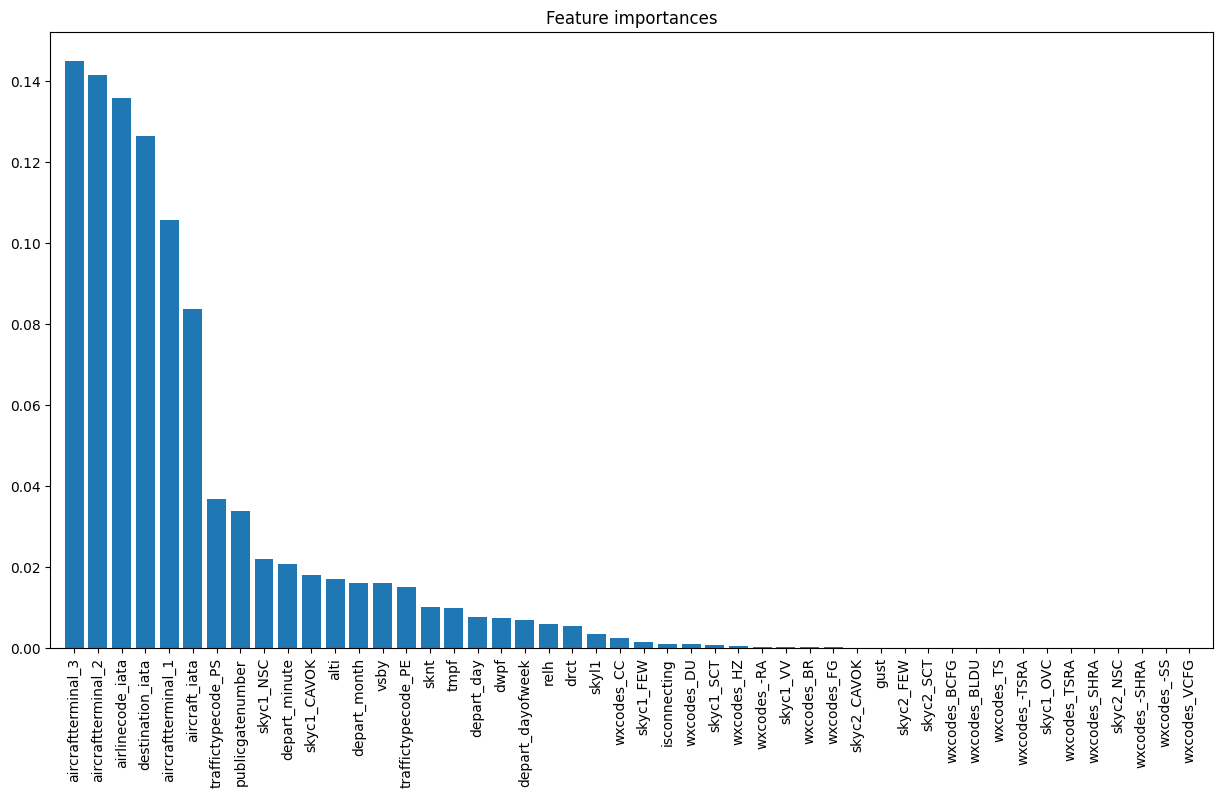

In [449]:
import matplotlib.pyplot as plt
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [ ]:
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_space,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)
bayes_cv.fit(X_train_balanced, y_train_balanced)
best_rf = bayes_cv.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Performance without clustering:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("==========================================")
print()


Original class distribution:
finalflightstatus
0    142456
1     55488
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    142456
1    142456
Name: count, dtype: int64
Performance without clustering:
Accuracy: 0.670196213146887
Precision: 0.4383040935672515
Recall: 0.09428265928674759
F1 Score: 0.15518401573580412



In [82]:
hdbscan_model = HDBSCAN(
    min_cluster_size=10000,      # Increase to avoid microclusters
    min_samples=10,              # Lower to reduce noise points
    cluster_selection_epsilon=0.5,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True,
    core_dist_n_jobs=-1
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

Cluster
 3    73040
-1    34889
 0    33588
 2    31025
 1    25402
Name: count, dtype: int64

In [87]:
clusters_test, _ = approximate_predict(hdbscan_model, X_test)
pd.Series(clusters_test).value_counts()

-1    6402
 9    6066
 8    2232
 4    1925
 7    1388
 1     612
 0     242
 2     181
 3      32
 6       1
Name: count, dtype: int64

In [ ]:
probs_test = membership_vector(hdbscan_model, X_test.to_numpy())
pd.DataFrame(probs_test).describe()


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [89]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test


In [96]:
rf_models = {}
metrics = {}
model_weights_f1 = {}
model_weights_cluster = {}
entropy_weights = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue
    
    print(f'Cluster {cluster}')

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cluster = y_train.loc[X_cluster.index]
    
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cluster = y_test.loc[X_test_cluster.index]
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_cluster, y_cluster)

# Print class distribution before and after SMOTE
    print("Original class distribution:")
    print(pd.Series(y_cluster).value_counts())
    print("\nBalanced class distribution:")
    print(pd.Series(y_train_balanced).value_counts())

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        scoring='f1',
        random_state=42
    )
    bayes_cv.fit(X_train_balanced, y_train_balanced)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf
    
    # Cluster weighted
    cluster_weight = len(y_cluster) / len(y_train)
    model_weights_cluster[cluster] = cluster_weight
    
    # f1 weighted
    model_weights_f1[cluster] = bayes_cv.best_score_
    
    # entropy weighted
    predictions = best_rf.predict(X_cluster)
    relative_errors = (predictions != y_cluster).astype(int)
    p_error = relative_errors.sum() / len(relative_errors)
    entropy = -p_error * np.log(p_error + 1e-9) - (1 - p_error) * np.log(1 - p_error + 1e-9)
    weight = 1 - entropy
    entropy_weights[cluster] = weight
    
    print(f"Cluster {cluster} best f1 score: {bayes_cv.best_score_}")


Cluster 0
Original class distribution:
finalflightstatus
0    2231
1     877
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    2231
1    2231
Name: count, dtype: int64
Cluster 0 best f1 score: 0.5926467719816508
Cluster 1
Original class distribution:
finalflightstatus
0    3489
1    1304
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    3489
1    3489
Name: count, dtype: int64
Cluster 1 best f1 score: 0.5636199627475283
Cluster 2
Original class distribution:
finalflightstatus
0    3095
1    1391
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    3095
1    3095
Name: count, dtype: int64
Cluster 2 best f1 score: 0.5942078131591209
Cluster 3
Original class distribution:
finalflightstatus
0    4054
1    1856
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    4054
1    4054
Name: count, dtype: int64
Cluster 3 best f1 score: 0.5268872939019653
Cluster 4
Original class distributio

In [97]:
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    }
bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    scoring='f1_weighted',
    random_state=42
)
bayes_cv.fit(X_train[X_train['cluster'] != -1].drop(columns=['cluster']), X_train['cluster'][X_train['cluster'] != -1])
print(bayes_cv.best_score_)
pre_classifier = bayes_cv.best_estimator_
pre_classifier_probabilities = pre_classifier.predict_proba(X_test.drop(columns=['cluster']))

0.9863383175936203


In [98]:
cluster_centers = {c: X_train[X_train['cluster'] == c].drop(columns=['cluster']).mean() for c in rf_models.keys()}

In [99]:
total_entropy_weight = sum(entropy_weights.values())
for model_cluster in entropy_weights:
    entropy_weights[model_cluster] /= total_entropy_weight

In [100]:
model_weights_f1

{0: 0.5926467719816508,
 1: 0.5636199627475283,
 2: 0.5942078131591209,
 3: 0.5268872939019653,
 4: 0.5866064925114153,
 5: 0.5743078202437166,
 6: 0.542693055731273,
 7: 0.5507658954819468,
 8: 0.5311992401565029,
 9: 0.5804514517876889}

In [101]:
# Make final predictions on the test set using weighted average
final_predictions_f1_weighted = []
final_predictions_cluster_weighted = []
final_predictions_probability_weighted = []
final_predictions_non_weighted = []
final_predictions_pre_classifier = []
final_predictions_entropy_weighted = []
all_y_true = []
for idx in X_test.index:
    cluster = X_test.loc[idx, 'cluster']
    if cluster == -1:
        # Find nearest cluster using euclidean distance to cluster centroids
        X_point = X_test.drop(columns=['cluster']).loc[idx]
        min_dist = float('inf')
        nearest_cluster = None
        
        for c in rf_models.keys():
            # Calculate distance to precalculated centroid
            centroid = cluster_centers[c]
            dist = np.sqrt(((X_point - centroid) ** 2).sum())
            if dist < min_dist:
                min_dist = dist
                nearest_cluster = c
                
        cluster = nearest_cluster
        
    probabilities_hdbscan = probs_test[idx]
    probabilities_pre_classifier = pre_classifier_probabilities[idx]
    
    votes_weighted_f1 = {}
    votes_weighted_cluster = {}
    votes_probability = {}
    votes_pre_classifier = {}
    votes_entropy_weighted = {}
    for model_cluster, model in rf_models.items():
        prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        weight_f1 = model_weights_f1.get(model_cluster, 0)
        if prediction in votes_weighted_f1:
            votes_weighted_f1[prediction] += weight_f1
        else:
            votes_weighted_f1[prediction] = weight_f1

        weight_cluster = model_weights_cluster.get(model_cluster, 0)
        if prediction in votes_weighted_cluster:
            votes_weighted_cluster[prediction] += weight_cluster
        else:
            votes_weighted_cluster[prediction] = weight_cluster
            
        if prediction in votes_probability:
            votes_probability[prediction] += probabilities_hdbscan[model_cluster]
        else:
            votes_probability[prediction] = probabilities_hdbscan[model_cluster]
        
        if prediction in votes_pre_classifier:
            votes_pre_classifier[prediction] += probabilities_pre_classifier[model_cluster]
        else:
            votes_pre_classifier[prediction] = probabilities_pre_classifier[model_cluster]
            
        if prediction in votes_entropy_weighted:
            votes_entropy_weighted[prediction] += entropy_weights[model_cluster]
        else:
            votes_entropy_weighted[prediction] = entropy_weights[model_cluster]
        
        
    model = rf_models[cluster]
    prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
    final_predictions_non_weighted.append(round(prediction))   
    

    # Final prediction is the weighted average
    final_prediction_f1_weighted = max(votes_weighted_f1, key=votes_weighted_f1.get)
    final_predictions_f1_weighted.append(final_prediction_f1_weighted)
    
    final_prediction_cluster_weighted = max(votes_weighted_cluster, key=votes_weighted_cluster.get)
    final_predictions_cluster_weighted.append(final_prediction_cluster_weighted)
    
    final_prediction_probability_weighted = max(votes_probability, key=votes_probability.get)
    final_predictions_probability_weighted.append(final_prediction_probability_weighted)
    
    final_prediction_pre_classifier = max(votes_pre_classifier, key=votes_pre_classifier.get)
    final_predictions_pre_classifier.append(final_prediction_pre_classifier)
    
    final_prediction_entropy_weighted = max(votes_entropy_weighted, key=votes_entropy_weighted.get)
    final_predictions_entropy_weighted.append(final_prediction_entropy_weighted)
    
    all_y_true.append(y_test.loc[idx])


In [104]:
# Calculate overall metrics
##########################
# Weighted Average F1 Ensemble
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_f1_weighted)
overall_precision = precision_score(all_y_true, final_predictions_f1_weighted)
overall_recall = recall_score(all_y_true, final_predictions_f1_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_f1_weighted)

print("\nOverall Metrics (Weighted Average F1 Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##########################
# Weighted Average Cluster Size Ensemble
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_cluster_weighted)
overall_precision = precision_score(all_y_true, final_predictions_cluster_weighted)
overall_recall = recall_score(all_y_true, final_predictions_cluster_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_cluster_weighted)

print("\nOverall Metrics (Weighted Average Cluster Size Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##########################
# Weighted Average Probability Ensemble
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_probability_weighted)
overall_precision = precision_score(all_y_true, final_predictions_probability_weighted)
overall_recall = recall_score(all_y_true, final_predictions_probability_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_probability_weighted)

print("\nOverall Metrics (Weighted Average Probability Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##########################
# Non-Weighted Ensemble
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_non_weighted)
overall_precision = precision_score(all_y_true, final_predictions_non_weighted)
overall_recall = recall_score(all_y_true, final_predictions_non_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_non_weighted)

print("\nOverall Metrics (Non-Weighted):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##########################
# Pre-Classifier
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_pre_classifier)
overall_precision = precision_score(all_y_true, final_predictions_pre_classifier)
overall_recall = recall_score(all_y_true, final_predictions_pre_classifier)
overall_f1 = f1_score(all_y_true, final_predictions_pre_classifier)

print("\nOverall Metrics (Pre-Classifier):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##########################
# Entropy Weighted
##########################
overall_accuracy = accuracy_score(all_y_true, final_predictions_entropy_weighted)
overall_precision = precision_score(all_y_true, final_predictions_entropy_weighted)
overall_recall = recall_score(all_y_true, final_predictions_entropy_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_entropy_weighted)

print("\nOverall Metrics (Entropy Weighted):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Weighted Average F1 Ensemble):
Overall Accuracy: 0.6793669094911168
Overall Precision: 0.34872448979591836
Overall Recall: 0.27716950527169504
Overall F1 Score: 0.3088567555354722

Overall Metrics (Weighted Average Cluster Size Ensemble):
Overall Accuracy: 0.615481368901001
Overall Precision: 0.3151421983089931
Overall Recall: 0.41565287915652877
Overall F1 Score: 0.3584856168575675

Overall Metrics (Weighted Average Probability Ensemble):
Overall Accuracy: 0.6339290393585242
Overall Precision: 0.32286453839516827
Overall Recall: 0.3793592862935929
Overall F1 Score: 0.3488393772723035

Overall Metrics (Non-Weighted):
Overall Accuracy: 0.6123892877731775
Overall Precision: 0.3181818181818182
Overall Recall: 0.43714517437145173
Overall F1 Score: 0.3682951827810044

Overall Metrics (Pre-Classifier):
Overall Accuracy: 0.6188878989570777
Overall Precision: 0.3220802919708029
Overall Recall: 0.42944038929440387
Overall F1 Score: 0.3680917622523462

Overall Metrics (Entropy 

In [102]:
# final_predictions_entropy_weighted = []
# all_y_true = []
# for idx in X_test.index:
    
#     votes_entropy_weighted = {}
#     for model_cluster, model in rf_models.items():
#         prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        
#         if prediction in votes_entropy_weighted:
#             votes_entropy_weighted[prediction] += entropy_weights[model_cluster]
#         else:
#             votes_entropy_weighted[prediction] = entropy_weights[model_cluster]    

#     # Final prediction is the weighted average
#     final_prediction_entropy_weighted = max(votes_entropy_weighted, key=votes_entropy_weighted.get)
#     final_predictions_entropy_weighted.append(final_prediction_entropy_weighted)
    
#     all_y_true.append(y_test.loc[idx])
    
# overall_accuracy = accuracy_score(all_y_true, final_predictions_entropy_weighted)
# overall_precision = precision_score(all_y_true, final_predictions_entropy_weighted)
# overall_recall = recall_score(all_y_true, final_predictions_entropy_weighted)
# overall_f1 = f1_score(all_y_true, final_predictions_entropy_weighted)

# print("Overall Metrics (Entropy Weighted):")
# print(f"Overall Accuracy: {overall_accuracy}")
# print(f"Overall Precision: {overall_precision}")
# print(f"Overall Recall: {overall_recall}")
# print(f"Overall F1 Score: {overall_f1}")

In [52]:
# # Make final predictions on the test set using weighted average
# final_predictions_pre_classifier = []
# all_y_true = []
# for idx in X_test.index:
        
    
    
#     votes_pre_classifier = {}
#     for model_cluster, model in rf_models.items():
#         prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        
            

#     # Final prediction is the weighted average
#     final_prediction_pre_classifier = max(votes_pre_classifier, key=votes_pre_classifier.get)
#     final_predictions_pre_classifier.append(final_prediction_pre_classifier)
    
#     all_y_true.append(y_test.loc[idx])

In [53]:
# overall_accuracy = accuracy_score(all_y_true, final_predictions_pre_classifier)
# overall_precision = precision_score(all_y_true, final_predictions_pre_classifier)
# overall_recall = recall_score(all_y_true, final_predictions_pre_classifier)
# overall_f1 = f1_score(all_y_true, final_predictions_pre_classifier)

# print("\nOverall Metrics (Pre-Classifier):")
# print(f"Overall Accuracy: {overall_accuracy}")
# print(f"Overall Precision: {overall_precision}")
# print(f"Overall Recall: {overall_recall}")
# print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Pre-Classifier):
Overall Accuracy: 0.6125465122373042
Overall Precision: 0.3161512027491409
Overall Recall: 0.42903487429034876
Overall F1 Score: 0.3640430107526882


In [54]:
# entropy_weights = {}
# for model_cluster, model in rf_models.items():
#     # Calculate the relative error of the sub-network
#     X_cluster = X_train[X_train['cluster'] == model_cluster].drop(columns=['cluster'])
#     y_cluster = y_train.loc[X_cluster.index]
#     predictions = model.predict(X_cluster)
#     relative_errors = (predictions != y_cluster).astype(int)
#     p_error = relative_errors.sum() / len(relative_errors)
        
#     # Calculate the entropy based on relative error
#     entropy = -p_error * np.log(p_error + 1e-9) - (1 - p_error) * np.log(1 - p_error + 1e-9)
#     weight = 1 - entropy
#     entropy_weights[model_cluster] = weight
    
# # Normalize weights


In [ ]:
# 

In [60]:
# total_weight = sum(entropy_weights.values())
# for model_cluster in entropy_weights:
#     entropy_weights[model_cluster] /= total_weight
# entropy_weights

{0: 0.10432004801356558,
 1: 0.10134829212649679,
 2: 0.09514352808084782,
 3: 0.09633512519255015,
 4: 0.10003645121486365,
 5: 0.09598469948262066,
 6: 0.1011535880558346,
 7: 0.102361315957685,
 8: 0.10035321546928196,
 9: 0.10296373640625374}